# AV Scheduling for household

### Initialize
* Inital functions and package
* Read input

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import networkx as nx
%matplotlib inline
# from DYNASMART_Process import *
from Modules import DYNASMART_Process as dy
# import preprocessing_read_skim_file as rs
from Modules import AV_functions as av
from Modules import Solve_DARP as sod
from Modules import Postprocess_DARP as pod
from gurobipy import *
from Modules import *
import datetime
import requests
import math
import importlib
%load_ext autoreload
%autoreload 2

In [2]:
#Read in the basic traveler and trips informationa and joint the houshold id
# traveler_info=pd.read_csv('input/traveler.csv')
personData=pd.read_csv('input/personData_1.csv')
person_type_dic=dict(zip(personData.person_id,personData.type))
# hh_temp=personData[['person_id','hh_id']]
# traveler_trips=pd.merge(traveler_info,hh_temp,how='left',on=['person_id'])
#Trip mode
#1 Drive alone free; 2 Drive alone pay; 3 Shared ride 2 free; 4 Shared ride 2 pay ;
#5 Shared ride 3+ free; 6 Shared ride 3+ pay; 7 Walk; 8 Bike; 9 Walk to local transit; 
#10 Walk to premium transit; 11 Drive to local transit; 12 Drive to premium transit; 
#13 Taxi; 14 School bus

# traveler_trips=pd.read_csv('input/traveler_trip_info.csv')
# #Calculate the expected trip travel time as trip start time of trip (i+1) - start time of trip i - activity time 
# traveler_trips['Diff_bet_starttime']=traveler_trips.starttime.diff()[1:]
# traveler_trips.Diff_bet_starttime=traveler_trips.Diff_bet_starttime.shift(-1)
# traveler_trips['Diff_bet_starttime'].apply(lambda x: 0 if x<0 else x)
# traveler_trips['travel_time']=traveler_trips.Diff_bet_starttime-traveler_trips.ActivityTime
# traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips,'travel_time']=1440-(traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['starttime']+traveler_trips.loc[traveler_trips.trip_counter==traveler_trips.num_trips]['ActivityTime'])
# traveler_trips.orig_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.dest_purpose.replace(['eatingout','work','discretionary','shop','work-based','work-related','escort','maintenance','school','visiting','university'],
#                                     ['EatingOut','Work','Discretionary','Shop','WorkBased','WorkBased','Escort','Maintenance','School','Visiting','University'],
#                                     inplace=True)
# traveler_trips.loc[:,'person_type']=traveler_trips.person_id.apply(lambda x: person_type_dic[x])
# value_latearr_penalty_per_min=pd.read_csv('input/LateArrPenalty.dat',sep='\t',index_col =0)
# value_earlyarr_penalty_per_min=pd.read_csv('input/EarlyArrPenalty.dat',sep='\t',index_col =0)
# early_penalty_threshold=pd.read_csv('input/EarlyArrPenaltyThreshold.dat',sep='\t',index_col=0)
# late_penalty_threshold=pd.read_csv('input/LateArrPenaltyThreshold.dat',sep='\t',index_col=0)

# traveler_trips.loc[:,'earlyarr_penalty']=traveler_trips.apply(lambda row: value_earlyarr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'latearr_penalty']=traveler_trips.apply(lambda row: value_latearr_penalty_per_min.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'early_penalty_threshold']=traveler_trips.apply(lambda row: early_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.loc[:,'late_penalty_threshold']=traveler_trips.apply(lambda row: late_penalty_threshold.loc[row.dest_purpose,row.person_type], axis=1)
# traveler_trips.to_csv('input/traveler_trip_info_improved.csv')
traveler_trips=pd.read_csv('input/traveler_trip_info_improved.csv')

num_zones,num_nodes,num_links,node_detail,node_id,link_detail,link_id=dy.read_network('input/network.dat')
nodexy=dy.read_xy('input/xy.dat')
superzone_filepath='Input/SuperZone.dat'
linktraveltime_filepath='Input/output_td_linktraveltime.dat'
superzone_map=dy.read_superzone_info(superzone_filepath)
origin_path='Input/origin.dat'
destination_path='Input/destination.dat'
origins,destinations,origin_links=dy.read_origin_destion(origin_path,destination_path)
VPNRSkim_folder_filepath='Input/vehicularPNRSkim'
Vehicular_Skim=dy.read_vehicle_skim(VPNRSkim_folder_filepath)
transit_skim_folderpath='Input/'
TransitMazTazFlag,drivingweight,walkingweight,TransitSkimTimeIntervalLength,MaxNumTransitSkimTimeInterval,WalkSpeed,transit_zone_candidates,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,three_link_walk=dy.read_transitskim(transit_skim_folderpath)
#origins,destinations=dy.read_origin_destion('input/origin.dat','input/destination.dat')

56 57 144


In [3]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
single_model_runtime=60*20
drivingcost_per_mile=1
reward_mode=0
darp_solutions=[]
cav_use_mode=1
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))

for num_cav in range(1,4):
    for share_ride_factor in [1,1.25,1.5]:
#         for time_window_flag in [0,1]:
        time_window_flag=0
        # num_cav=1
        # share_ride_factor=1.5
        # time_window_flag=0
        print('**************')
        print('Num_CAV',num_cav,share_ride_factor,time_window_flag)
        print('**************')
        darp_solutions.extend([sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length,
                                    reward_mode,drivingcost_per_mile,share_ride_factor,output_flag,run_mode,num_cav,
                                  cav_use_mode,time_window_flag,single_model_runtime)])

**************
Num_CAV 1 1 0
**************
start sovling problem at  2018-04-01 21:17:58.947705
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 1181 rows, 728 columns and 6721 nonzeros
Variable types: 52 continuous, 676 integer (676 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 392.006

Presolve removed 385 rows and 558 columns
Presolve time: 0.13s
Presolved: 796 rows, 170 columns, 2023 nonzeros
Variable types: 52 continuous, 118 integer (118 binary)

Root relaxation: objective 5.506227e+02, 136 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  550

Best objective 7.900074000000e+01, best bound 7.900074000000e+01, gap 0.0000%
################################
The total reward is 102.0 
The delay cost is  0.0 
The total travel cost is  22.99926
0.0
finish solving problem at  2018-04-01 21:18:08.217272
start sovling problem at  2018-04-01 21:18:14.237947
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 4053 rows, 2600 columns and 26212 nonzeros
Variable types: 100 continuous, 2500 integer (2500 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 3e+05]

Loaded MIP start with objective 508.704

Presolve removed 1304 rows and 2089 columns
Presolve time: 0.20s
Presolved: 2749 rows, 511 columns, 7458 nonzeros
Variable types: 100 continuous, 411 integer (411 binary)
Presolve removed 4 r

     0     0  579.49679    0   27  548.41067  579.49679  5.67%     -    0s
     0     0  578.86751    0   17  548.41067  578.86751  5.55%     -    0s
     0     0  578.86751    0   17  548.41067  578.86751  5.55%     -    0s
     0     2  578.86751    0   17  548.41067  578.86751  5.55%     -    0s
H 2437   872                     549.6206700  571.58639  4.00%   5.1    0s
 21917   758  557.03090   37   11  549.62067  558.26061  1.57%   8.2    5s

Cutting planes:
  Learned: 18
  Gomory: 23
  Cover: 8
  MIR: 25
  Flow cover: 42
  Inf proof: 66
  Zero half: 2

Explored 26913 nodes (223605 simplex iterations) in 5.69 seconds
Thread count was 8 (of 8 available processors)

Solution count 3: 549.621 548.411 392.006 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.496206700000e+02, best bound 5.496206700000e+02, gap 0.0000%
################################
The total reward is 651.0 
The delay cost is  1.0019999999999887 
The total travel cost is  100.37733
0.0
finish solving pro


Solution count 10: 488.07 484.922 484.126 ... 410.901

Optimal solution found (tolerance 1.00e-04)
Best objective 4.880697400000e+02, best bound 4.880697400000e+02, gap 0.0000%
################################
The total reward is 619.0 
The delay cost is  6.459250000000064 
The total travel cost is  124.47101
0.0
finish solving problem at  2018-04-01 21:21:27.783693
start sovling problem at  2018-04-01 21:21:28.361817
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 282 rows, 168 columns and 1243 nonzeros
Variable types: 24 continuous, 144 integer (144 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 157.449

Presolve removed 60 rows and 41 columns
Presolve time: 0.00s
Presolved: 222 rows, 

     0     0  689.03469    0   55  559.36784  689.03469  23.2%     -    1s
     0     0  689.03469    0   53  559.36784  689.03469  23.2%     -    1s
     0     0  689.03469    0   53  559.36784  689.03469  23.2%     -    1s
     0     0  689.03436    0   58  559.36784  689.03436  23.2%     -    1s
     0     0  688.97017    0   54  559.36784  688.97017  23.2%     -    1s
     0     0  688.97017    0   54  559.36784  688.97017  23.2%     -    1s
     0     0  688.97017    0   54  559.36784  688.97017  23.2%     -    1s
     0     2  688.97017    0   54  559.36784  688.97017  23.2%     -    1s
H   27    21                     567.4138400  687.51466  21.2%  22.9    2s
H 1445   962                     589.6003400  686.40179  16.4%   9.4    3s
H 1447   915                     592.7943400  686.40179  15.8%   9.4    4s
H 1448   869                     609.8803400  686.40179  12.5%   9.4    5s
H 1448   826                     626.5103400  686.40179  9.56%   9.4    5s
H 1453   788             

 137578 23433  677.42303   39   96  673.27934  680.48187  1.07%  32.8  435s
 140290 23530  678.16202   54  100  673.27934  680.40835  1.06%  33.1  442s
 141231 23601 infeasible   44       673.27934  680.37509  1.05%  33.2  445s
 143989 23732 infeasible   48       673.27934  680.30240  1.04%  33.4  451s
 145750 23787     cutoff   50       673.27934  680.25036  1.04%  33.6  456s
 147669 23883  678.50417   49   92  673.27934  680.20059  1.03%  33.7  461s
 149478 23902  676.32280   50   75  673.27934  680.14401  1.02%  33.9  466s
 151416 23924 infeasible   53       673.27934  680.09295  1.01%  34.0  470s
 153136 23917     cutoff   53       673.27934  680.04945  1.01%  34.1  475s
 155162 23962 infeasible   57       673.27934  680.00520  1.00%  34.3  480s
 157135 23991  678.51926   52   90  673.27934  679.93578  0.99%  34.4  485s
 159823 24086 infeasible   58       673.27934  679.86444  0.98%  34.6  492s
 161800 24096  674.04728   47   96  673.27934  679.81739  0.97%  34.7  497s
 163887 2411

Presolved: 860 rows, 459 columns, 4341 nonzeros
Variable types: 52 continuous, 407 integer (407 binary)

Root relaxation: objective 5.851378e+02, 229 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  585.13778    0   44  392.00650  585.13778  49.3%     -    0s
     0     0  580.03898    0   36  392.00650  580.03898  48.0%     -    0s
     0     0  579.80498    0   37  392.00650  579.80498  47.9%     -    0s
     0     0  579.68083    0   29  392.00650  579.68083  47.9%     -    0s
     0     0  579.64153    0   28  392.00650  579.64153  47.9%     -    0s
     0     0  579.61441    0   30  392.00650  579.61441  47.9%     -    0s
     0     0  579.57303    0   31  392.00650  579.57303  47.8%     -    0s
     0     0  579.49617    0   28  392.00650  579.49617  47.8%     -    0s
     0     0  579.49583    0   28  392.00650  579.49583  47.8%     -    0

  2823  1312  506.95343   32   87  488.92307  512.09477  4.74%  21.0   20s
  6760  2962  503.17821   28   82  488.92307  510.75316  4.46%  25.9   25s
 10516  4516  508.64050   26   83  488.92307  509.43471  4.20%  27.4   30s
 14872  6318 infeasible   34       488.92307  508.59635  4.02%  27.5   36s
 18303  7514  505.67025   37   48  488.92307  508.11088  3.92%  26.9   40s
 22322  8550 infeasible   42       488.92307  507.48363  3.80%  26.8   45s
 28056  9867  502.37696   32   80  488.92307  506.68396  3.63%  25.9   50s
 29835 10326  502.58777   52   83  488.92307  506.47465  3.59%  25.7   65s
 29862 10344  496.35901   58  108  488.92307  506.47465  3.59%  25.6   70s
 29876 10353  493.89060   45  118  488.92307  506.47465  3.59%  25.6   75s
 29884 10359  501.98464   26  114  488.92307  506.47465  3.59%  25.6   80s
 29892 10367  506.47465   25  115  488.92307  506.47465  3.59%  25.7   85s
 30777 10525  497.18650   63   29  488.92307  506.47465  3.59%  25.9   90s
 33134 10689  497.74752  

     0     0   81.21760    0   17   79.00074   81.21760  2.81%     -    0s
     0     0   81.13162    0   17   79.00074   81.13162  2.70%     -    0s
     0     0   81.11159    0   16   79.00074   81.11159  2.67%     -    0s
     0     0   81.10964    0   16   79.00074   81.10964  2.67%     -    0s
     0     0   81.09071    0   12   79.00074   81.09071  2.65%     -    0s
     0     0   81.09071    0   14   79.00074   81.09071  2.65%     -    0s
     0     0   80.98146    0   13   79.00074   80.98146  2.51%     -    0s
     0     0   80.94138    0   14   79.00074   80.94138  2.46%     -    0s
     0     0   80.89294    0   13   79.00074   80.89294  2.40%     -    0s
     0     0   80.89079    0   13   79.00074   80.89079  2.39%     -    0s
     0     0   80.88957    0   13   79.00074   80.88957  2.39%     -    0s
     0     0   80.88595    0   13   79.00074   80.88595  2.39%     -    0s
     0     0   80.87079    0   13   79.00074   80.87079  2.37%     -    0s
     0     0   80.87024  

 29790 13091  677.43407   56  123  673.65359  682.73626  1.35%  27.5  190s
 29796 13095  676.78968   41  134  673.65359  682.73626  1.35%  27.5  195s
 29802 13099  680.56634   39  130  673.65359  682.73626  1.35%  27.5  200s
 29808 13103  682.21319   34  133  673.65359  682.73626  1.35%  27.5  205s
 29813 13106  680.08242   34  142  673.65359  682.73626  1.35%  27.5  210s
 29819 13110  676.33639   63  130  673.65359  682.73626  1.35%  27.5  215s
 29824 13113  677.63164   43  134  673.65359  682.73626  1.35%  27.5  220s
 29830 13117  677.43407   56  128  673.65359  682.73626  1.35%  27.5  225s
 29836 13121  676.78968   41  127  673.65359  682.73626  1.35%  27.5  230s
 29842 13125  680.56634   39  135  673.65359  682.73626  1.35%  27.5  235s
 29847 13129  677.06285   25  135  673.65359  682.73626  1.35%  27.5  240s
 29853 13133  680.08242   34  143  673.65359  682.73626  1.35%  27.5  245s
 29861 13138  682.73626   27  113  673.65359  682.73626  1.35%  28.0  250s
 30546 13178  682.11823  

 229826 69008  673.98779   75   34  673.65359  679.67654  0.89%  28.5  736s
 231762 69471  678.57548   75   74  673.65359  679.66020  0.89%  28.5  741s
 233708 69981     cutoff   71       673.65359  679.65071  0.89%  28.5  746s
 235690 70499  676.74952   67   64  673.65359  679.63733  0.89%  28.5  751s
 237658 70984  675.87188   49   74  673.65359  679.62422  0.89%  28.5  756s
 239331 71485  677.93277   70   26  673.65359  679.61467  0.88%  28.5  761s
 241003 71901  677.89663   50   75  673.65359  679.59726  0.88%  28.5  767s
 242988 72415 infeasible   57       673.65359  679.58376  0.88%  28.6  772s
 243967 72657  677.24797   67   68  673.65359  679.57758  0.88%  28.6  775s
 246076 73209     cutoff   78       673.65359  679.55997  0.88%  28.5  780s
 247860 73623 infeasible   62       673.65359  679.54743  0.87%  28.5  785s
 249850 74162  676.20598   58  119  673.65359  679.53452  0.87%  28.5  790s
 251751 74659  675.26425   56   92  673.65359  679.52224  0.87%  28.5  795s
 253678 7516

  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 392.007

Presolve removed 1209 rows and 1106 columns
Presolve time: 0.17s
Presolved: 967 rows, 298 columns, 3167 nonzeros
Variable types: 52 continuous, 246 integer (246 binary)

Root relaxation: objective 5.559657e+02, 180 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  555.96567    0    9  392.00650  555.96567  41.8%     -    0s
H    0     0                     401.3350000  555.96567  38.5%     -    0s
H    0     0                     442.0260000  555.96567  25.8%     -    0s
H    0     0                     501.7630000  555.96567  10.8%     -    0s
H    0     0                     516.8896700  555.96567  7.56%     -    0s
     0     0  555.96567    0   48  516.88967  555.96567

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      83.9997400   83.99974  0.00%     -    0s

Explored 0 nodes (52 simplex iterations) in 0.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 83.9997 79.0007 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.399974000000e+01, best bound 8.399974000000e+01, gap 0.0000%
################################
The total reward is 102.0 
The delay cost is  0.0 
The total travel cost is  18.00026
0.0
finish solving problem at  2018-04-01 22:00:54.719366
start sovling problem at  2018-04-01 22:01:00.500604
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 7733 rows, 5100 columns and 51874 nonzeros
Variable types: 100 continuous, 5000 integer (5000 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+

     0     2  586.65017    0   63  542.30167  586.65017  8.18%     -    1s
H  378   212                     550.3956700  585.29830  6.34%  12.2    2s
H 2042   944                     552.2736700  583.06050  5.57%   8.4    3s
  2420  1046  583.06050   44   58  552.27367  583.06050  5.57%  10.7    5s
* 5191  1727              91     553.5726700  583.06050  5.33%   9.0    5s
*13000  4698              64     555.4286700  582.52673  4.88%   7.8    8s
 23165  7763  578.20462   58    9  555.42867  581.59946  4.71%   7.5   10s
 29296  9584  576.68726   53   61  555.42867  581.01439  4.61%   7.4   16s
 29314  9596  568.00167   62   98  555.42867  581.01439  4.61%   7.4   20s
 29330  9607  563.96198   67  103  555.42867  581.01439  4.61%   7.4   25s
 29349  9619  571.23359   40  103  555.42867  581.01439  4.61%   7.4   30s
 29367  9631  572.32950   73  112  555.42867  581.01439  4.61%   7.4   35s
 30024  9703  578.63898   51   13  555.42867  581.01439  4.61%   7.8   40s
 38087 10052  558.84779  

     0     0  534.41512    0  141  457.06524  534.41512  16.9%     -    3s
     0     0  534.41512    0  141  457.06524  534.41512  16.9%     -    3s
     0     2  534.41512    0  141  457.06524  534.41512  16.9%     -    4s
H   36    28                     474.7049900  532.00915  12.1%  67.0    4s
   170   129  524.51251   17   85  474.70499  532.00915  12.1%  36.9    5s
  1481   946  523.83423   46  183  474.70499  530.12404  11.7%  20.4   10s
  1494   957  527.54895   16  132  474.70499  529.95508  11.6%  23.5   15s
  2276  1272  509.80799   28   95  474.70499  529.21979  11.5%  33.4   20s
H 2279  1215                     486.5709900  529.21979  8.77%  33.5   20s
  3736  1766  518.74173   34   71  486.57099  527.62410  8.44%  36.9   25s
  5774  2970  515.06482   60  108  486.57099  527.09888  8.33%  36.7   30s
  7547  3998  523.82272   34  126  486.57099  526.27259  8.16%  39.2   35s
H 7868  4207                     486.6409900  526.24182  8.14%  39.3   35s
H 7926  4228             

 56307 13474  510.24161   53  103  504.17699  515.55137  2.26%  58.9  488s
 57244 13598  512.19081   38   78  504.17699  515.51069  2.25%  59.1  492s
 58087 13666  506.11806   76   87  504.17699  515.47446  2.24%  59.3  496s
 58967 13779  509.38080   44   58  504.17699  515.42523  2.23%  59.4  500s
 60605 13904  509.99231   79  143  504.17699  515.30714  2.21%  59.8  508s
 61444 13932     cutoff   71       504.17699  515.28098  2.20%  60.0  512s
 62205 14191 infeasible   49       504.17699  515.24033  2.19%  60.2  516s
 63118 14530  509.98783   56  119  504.17699  515.21246  2.19%  60.4  520s
 64579 15018  504.74361   55   91  504.17699  515.14214  2.17%  60.9  528s
 65489 15322  511.36910   55  116  504.17699  515.07498  2.16%  61.0  533s
 66477 15655  511.28941   53  142  504.17699  515.02133  2.15%  61.1  537s
 67476 16092  511.07843   61  129  504.17699  514.96743  2.14%  61.2  541s
 68447 16469  513.09235   52  134  504.17699  514.92272  2.13%  61.2  545s
 70396 17136  510.07415  

 166971 24034  508.37871   66   99  507.63199  511.18594  0.70%  66.9 1025s
 168405 23944     cutoff   64       507.63199  511.14226  0.69%  66.9 1031s
 168998 23852  511.11781   75  140  507.63199  511.12329  0.69%  66.9 1035s
 170340 23691  510.32104   81  150  507.63199  511.08151  0.68%  66.9 1041s
 171555 23481  510.19990   64  144  507.63199  511.03987  0.67%  66.9 1047s
 172310 23460  510.53880   58  126  507.63199  511.02093  0.67%  66.9 1051s
 173606 23336     cutoff   46       507.63199  510.97693  0.66%  66.9 1057s
 174169 23222     cutoff   60       507.63199  510.95585  0.65%  66.9 1060s
 175481 23092  509.82173   46  124  507.63199  510.92012  0.65%  66.9 1065s
 176520 22869  510.86868   51  126  507.63199  510.87977  0.64%  66.9 1072s
 177162 22783  509.04904   54  113  507.63199  510.86269  0.64%  66.9 1075s
 178292 22566     cutoff   61       507.63199  510.82561  0.63%  66.8 1080s
 179447 22401     cutoff   68       507.63199  510.78537  0.62%  66.8 1086s
 180598 2220


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   85.44258    0   18   79.00074   85.44258  8.15%     -    0s
     0     0   85.41636    0   24   79.00074   85.41636  8.12%     -    0s
     0     0   85.41604    0   24   79.00074   85.41604  8.12%     -    0s
     0     0   85.29894    0   22   79.00074   85.29894  7.97%     -    0s
     0     0   85.29894    0   20   79.00074   85.29894  7.97%     -    0s
     0     0   85.28574    0   20   79.00074   85.28574  7.96%     -    0s
     0     0   85.28574    0    8   79.00074   85.28574  7.96%     -    0s
     0     0   85.28574    0    8   79.00074   85.28574  7.96%     -    0s
H    0     0                      83.9997400   85.28574  1.53%     -    0s
     0     0   85.28574    0   18   83.99974   85.28574  1.53%     -    0s
     0     0   85.28574    0   23   83.99974   85.28574  1.53%     -    0s
     0     0   85.28574

 29153 15273  694.03979   34  222  669.02509  696.83979  4.16%  15.1  185s
H29154 14508                     672.9050900  696.83979  3.56%  15.1  187s
 29158 14511  686.13937   27  203  672.90509  696.83979  3.56%  15.1  191s
 29162 14513  672.90509  139  204  672.90509  696.83979  3.56%  15.0  195s
 29166 14516  683.22765   48  213  672.90509  696.83979  3.56%  15.0  200s
 29172 14520  696.02001   55  208  672.90509  696.83979  3.56%  15.0  206s
 29176 14523  695.14507   33  202  672.90509  696.83979  3.56%  15.0  210s
 29181 14526  675.94852   77  219  672.90509  696.83979  3.56%  15.0  215s
 29186 14529  683.22765   48  206  672.90509  696.83979  3.56%  15.0  222s
 29189 14531  694.02286   38  215  672.90509  696.83979  3.56%  15.0  225s
 29195 14535  694.40957   21  212  672.90509  696.83979  3.56%  15.0  230s
 29200 14539  686.51254   44  204  672.90509  696.83979  3.56%  15.0  235s
 29204 14541  681.04841   41  210  672.90509  696.83979  3.56%  15.0  240s
 29210 14545  692.65820  

 164204 45819  694.42974   36  117  672.90509  695.27649  3.32%  30.4  725s
 166094 46162  692.22307   47  102  672.90509  695.27054  3.32%  30.5  730s
 168290 46542  690.53793   51   96  672.90509  695.25434  3.32%  30.4  736s
 169869 46852  694.85650   45  120  672.90509  695.23546  3.32%  30.5  741s
 171672 47225  692.20531   59   93  672.90509  695.22478  3.32%  30.5  746s
 173477 47583 infeasible   48       672.90509  695.21209  3.32%  30.6  751s
 175108 47896 infeasible   40       672.90509  695.20209  3.31%  30.6  756s
 177051 48386  690.85508   53  138  672.90509  695.18726  3.31%  30.7  761s
 178775 48869  684.99420   41  124  672.90509  695.17488  3.31%  30.7  767s
 179374 48990  691.19524   61  112  672.90509  695.17488  3.31%  30.7  770s
 181452 49371  695.06229   53  115  672.90509  695.16063  3.31%  30.8  776s
 183411 49856  690.48074   47  149  672.90509  695.14135  3.30%  30.9  781s
 184559 50220  691.25166   54  167  672.90509  695.14135  3.30%  31.0  786s
 186140 5047

Variable types: 52 continuous, 1352 integer (1352 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]

Loaded MIP start with objective 392.007

Presolve removed 857 rows and 538 columns
Presolve time: 0.05s
Presolved: 1295 rows, 866 columns, 8024 nonzeros
Variable types: 52 continuous, 814 integer (814 binary)

Root relaxation: objective 5.913533e+02, 302 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  591.35325    0   52  392.00650  591.35325  50.9%     -    0s
H    0     0                     501.7630000  591.35325  17.9%     -    0s
     0     0  588.91845    0   75  501.76300  588.91845  17.4%     -    0s
     0     0  588.47460    0   58  501.76300  588.47460  17.3%     -    0s
     0     0  588.45075    0   60  501.76300  588

     0     0  534.84004    0  136  411.43774  534.84004  30.0%     -    1s
     0     0  534.84004    0  138  411.43774  534.84004  30.0%     -    1s
     0     0  534.82714    0  114  411.43774  534.82714  30.0%     -    2s
     0     0  534.82631    0  131  411.43774  534.82631  30.0%     -    2s
     0     0  534.82631    0  134  411.43774  534.82631  30.0%     -    2s
     0     0  534.82631    0  136  411.43774  534.82631  30.0%     -    2s
     0     0  534.74546    0  134  411.43774  534.74546  30.0%     -    2s
     0     0  534.69441    0  146  411.43774  534.69441  30.0%     -    2s
     0     0  534.69441    0  148  411.43774  534.69441  30.0%     -    2s
     0     0  534.69441    0  150  411.43774  534.69441  30.0%     -    2s
     0     0  534.69441    0  152  411.43774  534.69441  30.0%     -    2s
     0     0  534.69441    0  146  411.43774  534.69441  30.0%     -    2s
     0     0  534.69441    0  144  411.43774  534.69441  30.0%     -    2s
     0     2  534.69441  

 29474 15452  523.18341   30  156  508.38624  523.73211  3.02%  34.0  457s
 29496 15463  521.65829   32  140  508.38624  523.73211  3.02%  34.2  460s
 29673 15510  518.42180   46   91  508.38624  523.73211  3.02%  34.4  465s
 29875 15540  522.47504   39  191  508.38624  523.73211  3.02%  34.7  470s
 30420 15720  515.95013   54  121  508.38624  523.12239  2.90%  35.4  475s
 31070 15849  519.23588   39  173  508.38624  522.15615  2.71%  36.4  480s
 31804 15942 infeasible   46       508.38624  521.60055  2.60%  37.3  485s
 32413 15960  517.30634   39  108  508.38624  521.04405  2.49%  38.1  490s
 33149 16014 infeasible   66       508.38624  520.71014  2.42%  38.8  495s
 34025 16108  514.27115   43  124  508.38624  520.43460  2.37%  39.6  500s
 34732 16198  510.66222   51   50  508.38624  520.11923  2.31%  40.4  505s
 35429 16227     cutoff   54       508.38624  519.84964  2.25%  41.2  511s
 35975 16268  510.10898   58   85  508.38624  519.73681  2.23%  41.8  515s
 36961 16393  511.01262  

 119101 19258  514.33609   51   94  512.12074  516.03003  0.76%  56.3 1065s
 120030 19379  514.78479   73  127  512.12074  516.00881  0.76%  56.4 1070s
 120911 19507  515.85817   47  133  512.12074  515.98896  0.76%  56.4 1076s
 121768 19557  514.77759   63  123  512.12074  515.96944  0.75%  56.5 1081s
 122657 19658  515.91097   44  156  512.12074  515.95472  0.75%  56.6 1087s
 123580 19784 infeasible   50       512.12074  515.93482  0.74%  56.6 1094s
 124583 19941  513.85079   62  150  512.12074  515.93330  0.74%  56.7 1099s
H124936 19997                     512.1252400  515.93330  0.74%  56.7 1099s
 125275 20077  515.91788   50  144  512.12524  515.91788  0.74%  56.7 1100s
 125318 19978     cutoff   84       512.12524  515.90704  0.74%  56.7 1105s
 126044 20090  513.43303   53  125  512.12524  515.89428  0.74%  56.7 1112s
 126510 20022  514.01577   56  114  512.12524  515.88731  0.73%  56.7 1118s
 127539 20120  514.91499   50  117  512.12524  515.86299  0.73%  56.7 1124s
 128525 2024

     0     0   85.28574    0   26   83.99974   85.28574  1.53%     -    0s
     0     0   85.28574    0   20   83.99974   85.28574  1.53%     -    0s
     0     0   85.28574    0   23   83.99974   85.28574  1.53%     -    0s
     0     0   84.84724    0   28   83.99974   84.84724  1.01%     -    0s
     0     0   84.69666    0   28   83.99974   84.69666  0.83%     -    0s
     0     0   84.64852    0   35   83.99974   84.64852  0.77%     -    0s
     0     0   84.64852    0   34   83.99974   84.64852  0.77%     -    0s
     0     2   84.64852    0   34   83.99974   84.64852  0.77%     -    0s

Cutting planes:
  Gomory: 1
  Clique: 5
  MIR: 9
  Zero half: 2

Explored 39 nodes (726 simplex iterations) in 0.25 seconds
Thread count was 8 (of 8 available processors)

Solution count 2: 83.9997 79.0007 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.399974000000e+01, best bound 8.399974000000e+01, gap 0.0000%
################################
The total reward is 102.0 
The delay

 29557 16689  696.54033   28  206  681.63884  696.54033  2.19%  46.5  303s
 29560 16689  696.54033   29  184  681.63884  696.54033  2.19%  46.5  306s
 29581 16696  695.73760   32  121  681.63884  696.54033  2.19%  46.6  310s
 29764 16756  694.73507   48  108  681.63884  696.54033  2.19%  46.9  315s
 30209 16871  688.17417   47  132  681.63884  696.54033  2.19%  46.9  320s
 30824 17094  696.17784   44  151  681.63884  696.54033  2.19%  46.8  325s
 31467 17259  696.54033   37  128  681.63884  696.54033  2.19%  46.5  330s
 32211 17468  691.84929   61  137  681.63884  696.54033  2.19%  46.4  335s
 33237 17848  689.93850   66  127  681.63884  696.54033  2.19%  46.4  340s
 33896 18048  693.31121   56  152  681.63884  696.54033  2.19%  46.5  345s
 34994 18422  682.17674   81   59  681.63884  696.54033  2.19%  46.3  351s
 35657 18583  694.26489   60  158  681.63884  696.54033  2.19%  46.3  355s
 36679 18848 infeasible   74       681.63884  696.54033  2.19%  46.5  360s
 37593 19080  685.51450  

 123428 47549  692.35018   60  116  682.66459  695.16631  1.83%  55.8  944s
 124797 48157  692.85596   59  124  682.66459  695.15360  1.83%  55.7  949s
 125405 48360  693.47601   66   76  682.66459  695.14707  1.83%  55.8  956s
 126568 48922  689.40719   63   97  682.66459  695.13586  1.83%  55.8  961s
 127130 49161  690.27738   62  115  682.66459  695.12936  1.83%  55.9  968s
 128203 49643  693.15262   51  138  682.66459  695.11929  1.82%  55.9  973s
 128654 49852     cutoff   57       682.66459  695.11347  1.82%  56.0  980s
 129693 50327  689.35603   64  114  682.66459  695.11007  1.82%  56.0  986s
 130189 50534  683.80563   58  118  682.66459  695.09981  1.82%  56.1  992s
 131087 50956 infeasible   49       682.66459  695.09059  1.82%  56.2  998s
 131816 51242  695.00128   63   97  682.66459  695.08524  1.82%  56.2 1005s
 132987 51762  690.73524   52  117  682.66459  695.07394  1.82%  56.3 1011s
 133809 52069  686.21597   68  116  682.66459  695.06626  1.82%  56.3 1019s
 135072 5271

     0     0  511.86649    0   71  508.83649  511.86649  0.60%     -    1s
     0     0  511.83891    0   63  508.83649  511.83891  0.59%     -    1s
H    0     0                     510.2939900  511.83891  0.30%     -    1s
     0     0  511.27902    0   63  510.29399  511.27902  0.19%     -    1s
     0     0  510.29652    0   10  510.29399  510.29652  0.00%     -    1s

Cutting planes:
  Learned: 3
  Gomory: 2
  Implied bound: 5
  MIR: 2

Explored 1 nodes (1282 simplex iterations) in 1.09 seconds
Thread count was 8 (of 8 available processors)

Solution count 8: 510.294 508.836 508.796 ... 406.63

Optimal solution found (tolerance 1.00e-04)
Best objective 5.102939900000e+02, best bound 5.102965169983e+02, gap 0.0005%
################################
The total reward is 619.0 
The delay cost is  0.0 
The total travel cost is  108.70601
0.0
finish solving problem at  2018-04-01 23:25:24.227647
start sovling problem at  2018-04-01 23:25:24.930773
Parameter OutputFlag unchanged
   Value:

H 2264   472                     682.4530900  683.04709  0.09%  13.9    6s

Cutting planes:
  Learned: 4
  Gomory: 9
  Cover: 16
  Implied bound: 2
  MIR: 15
  Inf proof: 24
  Zero half: 2

Explored 3860 nodes (62483 simplex iterations) in 8.17 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 682.453 682.3 682.219 ... 680.367

Optimal solution found (tolerance 1.00e-04)
Best objective 6.824530900000e+02, best bound 6.824530900000e+02, gap 0.0000%
################################
The total reward is 851.0 
The delay cost is  1.0280000000000005 
The total travel cost is  167.51891
0.0
finish solving problem at  2018-04-01 23:25:41.962077
**************
Num_CAV 3 1.25 0
**************
start sovling problem at  2018-04-01 23:25:44.055832
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 3135 rows, 2080 columns and 18647

################################
The total reward is 651.0 
The delay cost is  1.5915000000000008 
The total travel cost is  82.38383
0.019500000000001627
finish solving problem at  2018-04-01 23:29:50.073372
start sovling problem at  2018-04-01 23:29:54.042131
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 7190 rows, 4880 columns and 49423 nonzeros
Variable types: 80 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 3e+05]

Loaded MIP start with objective 406.63

Presolve removed 3215 rows and 1889 columns
Presolve time: 0.09s
Presolved: 3975 rows, 2991 columns, 28952 nonzeros
Variable types: 80 continuous, 2911 integer (2911 binary)

Root relaxation: objective 5.442261e+02, 1238 iterations, 0.09 s

H30192 20015                     492.4834900  534.27305  8.49%  40.9  359s
 30193 20015  520.31167   60  309  492.48349  534.23208  8.48%  40.9  360s
 30195 20017  510.00336  107  311  492.48349  534.21730  8.47%  40.9  370s
 30197 20018  530.52697   76  301  492.48349  534.20621  8.47%  40.9  380s
H30198 19017                     499.5954900  534.20299  6.93%  40.9  388s
H30199 18065                     507.6964900  534.19704  5.22%  40.9  389s
 30200 18066  533.17663   28  313  507.69649  534.19583  5.22%  40.9  393s
 30201 18067  527.88092   66  312  507.69649  534.18804  5.22%  40.9  399s
H30201 17162                     509.7714900  534.18502  4.79%  40.9  404s
 30203 17163  526.45640   61  311  509.77149  534.18247  4.79%  40.9  409s
 30204 17164  531.13807   26  315  509.77149  534.18156  4.79%  40.9  414s
 30205 17164  523.91803   79  299  509.77149  534.15688  4.78%  40.9  420s
H30205 16305                     512.0784900  534.15688  4.31%  40.9  420s
 30206 16306  534.15106  

 50848 23047 infeasible   59       512.07849  530.21377  3.54%  71.4 1056s
 51981 23451  519.99716   84  180  512.07849  530.15195  3.53%  72.2 1067s
 52242 23465  528.77321   42  250  512.07849  530.10019  3.52%  72.8 1076s
 52621 23540  521.88343   69  213  512.07849  530.09495  3.52%  73.6 1088s
 53785 23942  522.27335   93  138  512.07849  530.00390  3.50%  74.4 1102s
 54703 24232  519.59068   54  190  512.07849  529.94871  3.49%  75.0 1112s
 55204 24274  517.82524   43  141  512.07849  529.91115  3.48%  75.8 1122s
 55842 24388  522.80638   44   63  512.07849  529.85383  3.47%  76.6 1132s
 56398 24482  522.60482   66  142  512.07849  529.81884  3.46%  77.3 1143s
 57178 24702 infeasible   79       512.07849  529.73792  3.45%  78.0 1153s
 57728 24760  520.86148   85  147  512.07849  529.70439  3.44%  78.8 1165s
 58272 24816  526.97570   78  175  512.07849  529.68609  3.44%  79.6 1175s
 58839 24885  515.66725   60  166  512.07849  529.65149  3.43%  80.4 1187s
 59600 25032 infeasible  

start sovling problem at  2018-04-01 23:50:04.243738
Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter TIME_LIMIT to 1200.0
   Prev: 1e+100  Min: 0.0  Max: 1e+100  Default: 1e+100
Optimize a model with 11341 rows, 7600 columns and 73864 nonzeros
Variable types: 100 continuous, 7500 integer (7500 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 3e+05]

Loaded MIP start with objective 508.704

Presolve removed 5478 rows and 3230 columns
Presolve time: 0.19s
Presolved: 5863 rows, 4370 columns, 41198 nonzeros
Variable types: 100 continuous, 4270 integer (4270 binary)

Root relaxation: objective 7.166862e+02, 2295 iterations, 0.25 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  716.68620    0  120  508.70384  

 29181 17444  691.82684   78  294  681.75009  702.99356  3.12%  62.6  386s
 29184 17446  701.80452   27  276  681.75009  702.99356  3.12%  62.6  391s
 29186 17448  697.71759   55  297  681.75009  702.99356  3.12%  62.6  397s
 29188 17449  694.41044   61  303  681.75009  702.99356  3.12%  62.5  404s
 29190 17450  696.81687   57  307  681.75009  702.99356  3.12%  62.5  407s
 29191 17451  696.19984   58  292  681.75009  702.99356  3.12%  62.5  413s
 29192 17452  702.01614   70  299  681.75009  702.99356  3.12%  62.5  416s
 29194 17453  702.81898   33  270  681.75009  702.99356  3.12%  62.5  421s
 29196 17454  690.06804   56  293  681.75009  702.99356  3.12%  62.5  427s
 29197 17455  702.75606   31  276  681.75009  702.99356  3.12%  62.5  432s
 29199 17456  698.20479   32  281  681.75009  702.99356  3.12%  62.5  437s
 29200 17457  699.27586   69  286  681.75009  702.99356  3.12%  62.5  440s
 29203 17459  690.00557  101  301  681.75009  702.99356  3.12%  62.5  446s
 29204 17460  701.80452  

 29359 16683  698.20479   32  328  681.81409  702.99356  3.11%  62.2  938s
 29360 16684  699.27586   69  335  681.81409  702.99356  3.11%  62.2  940s
 29361 16684  691.82684   78  316  681.81409  702.99356  3.11%  62.2  945s
 29363 16686  690.00557  101  312  681.81409  702.99356  3.11%  62.2  951s
 29365 16687  695.09332   75  326  681.81409  702.99356  3.11%  62.2  956s
 29367 16690  702.99356   27  297  681.81409  702.99356  3.11%  64.7  968s
 29369 16691  702.99356   28  298  681.81409  702.99356  3.11%  64.8  975s
 29372 16693  702.99356   29  290  681.81409  702.99356  3.11%  64.8  983s
 29376 16696  702.99356   30  286  681.81409  702.99356  3.11%  64.9  990s
 29391 16698  702.99356   32  272  681.81409  702.99356  3.11%  65.1  995s
 29448 16714 infeasible   35       681.81409  702.99356  3.11%  65.4 1000s
 29542 16740  702.99356   40  178  681.81409  702.99356  3.11%  65.8 1005s
 29656 16764  702.66494   46  189  681.81409  702.99356  3.11%  66.0 1010s
 29886 16831  699.68537  

 29537  8867  583.81543   27  169  572.99517  585.54761  2.19%  15.2   65s
 29546  8873  582.35111   30  179  572.99517  585.54761  2.19%  15.2   70s
 29556  8879  580.44888   37  136  572.99517  585.54761  2.19%  15.2   75s
 29566  8886  582.35111   30  163  572.99517  585.54761  2.19%  15.2   80s
 29577  8893  583.81543   27  114  572.99517  585.54761  2.19%  15.2   85s
 29586  8899  582.35111   30  163  572.99517  585.54761  2.19%  15.2   90s
 29595  8905  584.16364   33  124  572.99517  585.54761  2.19%  15.2   95s
 29606  8913  582.35111   30  156  572.99517  585.54761  2.19%  15.2  100s
 29623  8925  582.23375   24  115  572.99517  585.54761  2.19%  15.5  105s
 29635  8933  584.16364   33  152  572.99517  585.54761  2.19%  15.5  110s
 29645  8940  585.37437   27  132  572.99517  585.54761  2.19%  15.5  115s
 29655  8946  584.16364   33  153  572.99517  585.54761  2.19%  15.5  120s
 29666  8957  585.54761   34   98  572.99517  585.54761  2.19%  15.6  125s
 31497  9076  574.12098  

 30674 21207  520.41986  125  297  503.41449  534.49026  6.17%  45.6  233s
 30675 21208  520.29492  115  292  503.41449  534.49026  6.17%  45.6  239s
 30676 21208  531.45327   54  303  503.41449  534.49026  6.17%  45.6  243s
 30677 21209  520.55563   83  284  503.41449  534.49026  6.17%  45.6  249s
 30679 21210  516.46026  109  296  503.41449  534.49026  6.17%  45.6  253s
 30680 21211  520.40133   61  291  503.41449  534.49026  6.17%  45.6  259s
 30681 21212  509.98705  196  300  503.41449  534.49026  6.17%  45.6  260s
 30683 21213  529.83034   59  310  503.41449  534.49026  6.17%  45.6  270s
 30685 21214  515.30008   64  290  503.41449  534.49026  6.17%  45.6  279s
 30687 21216  529.24451   71  310  503.41449  534.49026  6.17%  45.6  280s
 30689 21217  513.54230   51  299  503.41449  534.49026  6.17%  45.6  291s
 30691 21218  523.39891   63  317  503.41449  534.49026  6.17%  45.6  296s
 30692 21219  513.30385   56  311  503.41449  534.49026  6.17%  45.6  302s
 30693 21220  515.46308  

 30799 21290  516.46026  109  356  503.41449  533.38361  5.95%  45.4  813s
 30800 21291  520.40133   61  350  503.41449  533.38030  5.95%  45.4  819s
 30801 21292  509.98705  196  354  503.41449  533.37510  5.95%  45.4  823s
 30802 21292  514.27166   68  353  503.41449  533.37078  5.95%  45.4  829s
H30802 20224                     507.3129900  533.37078  5.14%  45.4  829s
 30803 20225  529.83034   59  356  507.31299  533.36825  5.14%  45.4  833s
 30804 20226  529.09223   64  339  507.31299  533.35196  5.13%  45.4  838s
 30805 20226  515.30008   64  352  507.31299  533.34591  5.13%  45.4  842s
 30806 20227  525.04769   45  350  507.31299  533.34373  5.13%  45.4  848s
 30807 20228  529.24451   71  355  507.31299  533.34305  5.13%  45.4  852s
 30808 20228  524.21531   55  353  507.31299  533.34173  5.13%  45.4  857s
 30809 20229  513.54230   51  358  507.31299  533.34151  5.13%  45.4  861s
 30810 20230  527.00868   71  359  507.31299  533.34138  5.13%  45.4  868s
 30811 20230  523.39891  

     0     0  227.25780    0   83  213.25482  227.25780  6.57%     -    0s
     0     0  227.25762    0   84  213.25482  227.25762  6.57%     -    0s
H    0     0                     216.5948200  227.25762  4.92%     -    0s
     0     0  227.24369    0   85  216.59482  227.24369  4.92%     -    0s
     0     0  227.24278    0   88  216.59482  227.24278  4.92%     -    0s
     0     0  227.24228    0   89  216.59482  227.24228  4.92%     -    0s
     0     0  227.24217    0   91  216.59482  227.24217  4.92%     -    0s
     0     0  227.21847    0   87  216.59482  227.21847  4.90%     -    0s
     0     0  227.21738    0   89  216.59482  227.21738  4.90%     -    0s
     0     0  227.21738    0   89  216.59482  227.21738  4.90%     -    0s
     0     0  227.21738    0   88  216.59482  227.21738  4.90%     -    0s
     0     2  227.21738    0   88  216.59482  227.21738  4.90%     -    0s
* 1594   256              27     216.9633200  223.01669  2.79%   7.9    0s

Cutting planes:
  Learne

  1586  1047  710.96651   20  251  656.29134  711.05491  8.34%  44.1   50s
  1812  1127  710.88761   30  265  656.29134  710.99184  8.33%  54.7   55s
H 1933  1116                     656.6073400  710.99184  8.28%  55.9   57s
  2056  1160 infeasible   36       656.60734  710.99184  8.28%  58.2   60s
H 2057  1110                     657.3023400  710.99184  8.17%  58.2   60s
H 2071  1071                     685.3108400  710.99184  3.75%  58.3   60s
  2395  1192  701.65866   47  135  685.31084  710.96651  3.74%  57.2   65s
  2680  1313  701.70848   58  193  685.31084  710.94844  3.74%  67.3   70s
  3085  1463  699.10952   45  171  685.31084  710.79004  3.72%  70.6   75s
  3518  1604  705.48956   22  266  685.31084  710.60073  3.69%  72.5   80s
  4109  1816  708.04756   23  207  685.31084  710.40712  3.66%  71.1   85s
  4675  2215  707.91049   39  137  685.31084  710.07904  3.61%  71.5   91s
H 4692  2202                     686.0058400  710.07904  3.51%  71.8   91s
  4906  2346  701.66790  

 30023 18553  698.03883  120   91  686.00584  704.05617  2.63%  66.0  670s
 30342 18653  702.67268   56  200  686.00584  703.95502  2.62%  66.0  679s
 30354 18644  702.66416   57  176  686.00584  703.95502  2.62%  66.1  680s
 30623 18757  697.45862   86  150  686.00584  703.95502  2.62%  66.5  685s
 30953 18894  693.55127  128  124  686.00584  703.95502  2.62%  66.6  690s
 31251 19004  701.55032   40  181  686.00584  703.56752  2.56%  67.0  695s
 31509 19130  695.85548   59   66  686.00584  703.51549  2.55%  67.5  700s
 31996 19338  701.92352   61  160  686.00584  703.51549  2.55%  67.4  706s
 32334 19492 infeasible   32       686.00584  703.44452  2.54%  68.1  711s
 32760 19661  702.07454   35  174  686.00584  703.44452  2.54%  68.7  717s
 32956 19722  696.81588   37  224  686.00584  703.44452  2.54%  69.1  720s
 33513 19910  703.06320   34  173  686.00584  703.42812  2.54%  69.5  727s
 33692 19978  696.94249   41  103  686.00584  703.40115  2.54%  70.3  730s
 34127 20158  701.62618  

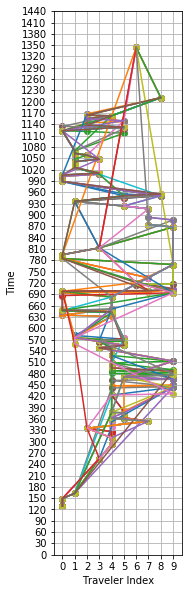

In [7]:
analyzed_results=pd.DataFrame()
for solution in darp_solutions:
    analyzed_results=analyzed_results.append(pod.analysis_result(solution,sorted_trips,Vehicular_Skim,superzone_map),ignore_index=True)

In [10]:
analyzed_results.transpose().to_csv('hh_level_result.csv')

In [12]:
analyzed_results.transpose()

,0,1,2,3,4,5,6,7,8
Total_early_time,-120.980000,-95.980000,-168.830000,-120.980000,-68.180000,-81.350000,-90.980000,-5.000000,-98.180000
cav_use_mode,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
drivingcost_per_mile,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
num_cav,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000
num_cav_trips,99.000000,102.000000,103.000000,99.000000,99.000000,99.000000,93.000000,97.000000,96.000000
num_convention car trips,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
num_delayed_trips,4.000000,4.000000,5.000000,4.000000,2.000000,7.000000,2.000000,4.000000,7.000000
num_early_trips,12.000000,14.000000,14.000000,12.000000,6.000000,11.000000,8.000000,2.000000,10.000000
num_occupied_trips,63.000000,68.000000,72.000000,63.000000,66.000000,72.000000,63.000000,67.000000,69.000000
num_pickup_trips,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,64.000000,64.000000


### Basic Statistics

In [ ]:
traveler_trips.head()

In [ ]:
traveler_trips.columns

In [ ]:
#Num of household
print('Number of household: \t',len(traveler_trips.hh_id.unique()))
print('Number of traveler: \t',len(traveler_trips.person_id.unique()))
print('Number of trips: \t',len(traveler_trips))
print('Number of indiv trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==0]))
print('Number of joint trip: \t',len(traveler_trips[traveler_trips.joint_trip_flag==1]))

In [ ]:
traveler_trips['orig_purpose'].value_counts().plot(kind='bar',title='Histogram of Origin Purpose')

In [ ]:
traveler_trips.tripmode.hist()

In [ ]:
traveler_trips.num_trips.hist()
plt.pyplot.title('Histogram of trip per person')

In [ ]:
traveler_trips.groupby('hh_id')['num_trips'].count().hist()
plt.pyplot.title('Histogram of trip per household')

### Sample Household
Select household 2287301 for intial analysis

In [ ]:
target_hh_id=2287301
people_in_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id]['person_id'].unique()
for person in people_in_hh:
    #creat trip-chain-origin-destination-list
    num_trips=traveler_trips[traveler_trips['person_id']==person]['num_trips'].iloc[0]
    print(num_trips)
    trip_chain_or=traveler_trips[traveler_trips['person_id']==person][['origin_node','destination_node']]
    trip_chain_or['origin_node'].iloc[1:num_trips-1]=trip_chain_or['destination_node'].iloc[0:num_trips-2].tolist()
    trip_chain_or['origin_node'].iloc[num_trips-1]=trip_chain_or['destination_node'].iloc[num_trips-2]
    #draw the graph
    av.trip_chain_highlight(trip_chain_or,node_detail,link_detail,nodexy)
#traveler_trips[traveler_trips['hh_id']==2105189]

### Solve the optimization for a household 

The factors need to know about:  
1. Decision variable X <sub>ij</sub> and T<sub>j</sub> (departure time from node j)  
2. R <sub>i</sub> reward of visiting node i
3. S <sub>i</sub> penalty for late/early arrival
4. C <sub>ij</sub> travel time between node i and j  
5. 

#### Solve with heuristic

## Estimate travel time and cost

## Solve the optimization with Gurobi

In [ ]:
drivingcost_per_mile=1
transit_fare=2
transit_asc=2

##### Try to solve the problem for a single household

#### Solve with exact method

In [ ]:
print('prepare input for dial n ride model at ',datetime.datetime.now())
output_flag=1
target_hh_id=2287301
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
# R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
R=estimate_trip_reward(hh_num_trips,sorted_trips,Vehicular_Skim)
print('start sovling problem at ',datetime.datetime.now())
m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sorted_trips,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode=)
print('finish solving problem at ',datetime.datetime.now())
route_info=extract_route_from_model_solution(x,T,sorted_trips,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
print('extract solution at',datetime.datetime.now())
route_info.to_csv('route_info_yingjie.csv')

In [ ]:
T_sol=np.ones(2*hh_num_trips+2)
for i in range(2*hh_num_trips+2):
#     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
    T_sol[i]=T[i].x
schedule_deviation=T_sol-expected_arrival_time
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,schedule_deviation)

#### Solve with the schedule partition heuristic

In [ ]:
def analysis_result(route_info,sorted_trips,Vehicular_Skim,schedule_deviation):
    print('Number of CAV Trips',len(route_info))
    print('Number of Occupied trips',len(route_info.loc[route_info.person_id>0]))
    print('Number of unoccupied trips',len(route_info.loc[route_info.person_id==0]))
    print('Number of pickup trips',len(route_info.loc[route_info.orig_node_index<=len(sorted_trips)]))
    print('Number of shared trips',len(route_info.loc[(route_info.orig_node_index<=len(sorted_trips)) &(route_info.dest_node_index<=len(sorted_trips))]))
    print('Number of convention car trips',len(sorted_trips.loc[sorted_trips.tripmode<=6]))
    # Compare the VHT between convention vehicle and CAV
    
    total_convention_vehicle_driving_time=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row:estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_driving_time=route_info.apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    total_AV_unoccupied_driving_time=route_info.loc[route_info.person_id==0].apply(lambda row: estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,2),axis=1).sum()
    print('Convention car trips VHT: \t',total_convention_vehicle_driving_time/60,
          '\nAV driving time: \t',total_AV_driving_time/60,
          '\nAV unoccupied driving_time: \t',total_AV_unoccupied_driving_time/60)
    # Compare the VMT between convention vehicle and CAV
    total_convention_vehicle_driving_distance=sorted_trips.loc[sorted_trips.tripmode<=6].apply(lambda row: estimate_single_car_trip_cost(row.orig_taz,row.dest_taz,row.starttime,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    total_AV_driving_distance=route_info.apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1) ,axis=1).sum()
    total_AV_unoccupied_driving_distance=route_info.loc[route_info.person_id==0].apply(lambda row:estimate_single_car_trip_cost(row.orig_zone,row.dest_zone,row.start_time,row.value_of_time,Vehicular_Skim,1),axis=1).sum()
    print('Convention VMT: \t',total_convention_vehicle_driving_distance,
          '\nAV driving distance: \t',total_AV_driving_distance,
          '\nAV unoccupied driving_distance: \t',total_AV_unoccupied_driving_distance)
    print('Number of delayed trips\t',sum(1 for i in schedule_deviation if i >1))
    print('Number of early trips\t',sum(1 for i in schedule_deviation if i <-1))
    print('Total delayed time\t',sum(i for i in schedule_deviation if i >0))
    print('Total_early_time\t',sum(i for i in schedule_deviation if i <0))
    plt.pyplot.figure(1,figsize=[2.3,10])
    plot_route_info_schedule(route_info,sorted_trips)
    return

In [ ]:
def plot_route_info_schedule(route_info,sorted_trips):
#     z=traveler_trips[traveler_trips.hh_id==route_info.hh_id[0]]
    sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
    hh_num_trips=len(sorted_trips)
    person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
    person_id_and_inhouse_p_id_map[0]=-1
    route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
    
    plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
                    route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'origin_arrival_time'])
#     plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) & (route_info.dest_node_index<1+hh_num_trips),'p_id'],
#                     route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips) &(route_info.dest_node_index<1+hh_num_trips),'origin_arrival_time'])
    plt.pyplot.xlabel('Traveler Index')
    plt.pyplot.ylabel('Time')
    plt.pyplot.grid()
    plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
    plt.pyplot.yticks(np.arange(0,1441,30))
#     plt.pyplot.title(title)
    return 

#### All trips take CAV

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
share_ride_factor=2
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_partition,all_trips_schedule_deviation=sod.solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_partition,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation)

#### Strict time window

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=2
time_window_flag=1
num_poav=2
single_model_runtime=60*5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_stricttw,all_trips_schedule_deviation_stricttw=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_stricttw,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_stricttw)

##### Only car trips take CAV

In [ ]:
len(sorted_car_trips)

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=0
reward_mode=0
time_window_flag=0
single_model_runtime=60*3
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
sorted_car_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_car_trips.shape[0]
sorted_car_trips["hh_index"]=(range(hh_num_trips))
car_trips_route_info_partition,car_trips_schedule_deviation=solve_with_schedule_partition(sorted_car_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(car_trips_route_info_partition,sorted_car_trips,Vehicular_Skim,car_trips_schedule_deviation)

#### Ban Shared Rides

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_ban_sharerides,all_trips_schedule_deviation_ban_sharerides=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_ban_sharerides,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_ban_sharerides)

#### Share ride factor 1.25

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
share_ride_factor=1.25
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
all_trips_route_info_sharerides125,all_trips_schedule_deviation_sharerides125=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
analysis_result(all_trips_route_info_sharerides125,sorted_trips,Vehicular_Skim,all_trips_schedule_deviation_sharerides125)

In [ ]:
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(142)
plot_route_info_schedule(car_trips_route_info_partition,sorted_car_trips)
plt.pyplot.subplot(143)
plot_route_info_schedule(all_trips_route_info_partition,sorted_trips)
plt.pyplot.subplot(144)
plot_route_info_schedule(all_trips_route_info_ban_sharerides,sorted_trips)

#### Probability Mode Choice

In [ ]:
drivingcost_per_mile=1
transit_fare=1.4
transit_asc=2

In [ ]:
output_flag=1
target_hh_id=2287301
# target_hh_id=2744264
min_length=15
max_length=20
run_mode=1
share_ride_factor=1.5
target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime','joint_trip_flag'])
#Sort all trips based on start time. This step could reduce the solving time and make it easier to track
sorted_trips=target_hh.sort_values("starttime")
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
mode_choice_route_info,mode_choice_schedule_deviation=solve_with_schedule_partition(sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)

In [ ]:
sorted_trips=compare_mode_utlity(sorted_trips)

In [ ]:
min_length=15
max_length=20
run_mode=0
share_ride_factor=1.5
force_serve_factor=1
car_sorted_trips=sorted_trips.loc[sorted_trips.expected_mode=='Car']
# sorted_trips=sorted_trips.loc[sorted_trips.tripmode<=6]
#hh_index give an index to all trips within the household for tracking purpose
hh_num_trips=sorted_trips.shape[0]
sorted_trips["hh_index"]=(range(hh_num_trips))
car_only_mode_choice_route_info,car_only_mode_choice_schedule_deviation=solve_with_schedule_partition(car_sorted_trips,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map,min_length,max_length)
force_serve_factor=0

In [ ]:
sorted_trips[['transit_time','transit_walk_time','car_time','toll_cost','car_dist','transit_utility','car_utility','expected_mode','actual_mode','value_of_time']]

In [ ]:
# sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]
# sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
# route_info=pd.DataFrame()

# total_previous_sub_trips_length=0
# total_tailing_sub_trips_length=0
# schedule_deviation=[]
# x_list=[]
# for sub_sorted_trip in sub_sorted_trips:

#     num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
#     # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
#     R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
#     print('start sovling problem at ',datetime.datetime.now())
#     m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,output_flag)
#     x_list.extend([x])
#     print('finish solving problem at ',datetime.datetime.now())
#     sub_route_info=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
#     total_tailing_sub_trips_length=len(sorted_trips)-total_previous_sub_trips_length-len(sub_sorted_trip)
#     sub_route_info['orig_node_index']=sub_route_info.orig_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     sub_route_info['dest_node_index']=sub_route_info.dest_node_index.apply(lambda x: x+total_previous_sub_trips_length if x<=hh_num_trips else x+2*total_previous_sub_trips_length+total_tailing_sub_trips_length) 
#     total_previous_sub_trips_length=total_previous_sub_trips_length+len(sub_sorted_trip)
#     route_info=route_info.append(sub_route_info)
# #         for index, row in route_info.iterrows():
# #             print(route_info.dest_expected_arrival_time,'\t',row.dest_arrival_time,'\t',row.start_time,'\t',T[row.dest_node_index].x)
# #         #Estimate the delay and early arrival
# T_sol=np.ones(2*hh_num_trips+2)
# for i in range(2*hh_num_trips+2):
# #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
#     T_sol[i]=T[i].x
#     print(T_sol[i],expected_arrival_time[i])
# schedule_deviation.extend(T_sol-expected_arrival_time)

In [ ]:
sorted_trips.loc[:,'p_id']=sorted_trips.groupby(['person_id']).ngroup()
hh_num_trips=len(sorted_trips)
person_id_and_inhouse_p_id_map=dict(zip(sorted_trips.person_id,sorted_trips.p_id))
person_id_and_inhouse_p_id_map[0]=-1
plt.pyplot.figure(1,figsize=[21,10])
plt.pyplot.subplot(141)
plot_route_info_schedule(car_only_mode_choice_route_info,car_sorted_trips)
z1=[sorted_trips.iloc[i-1].p_id for i in temp3]
z2=[sorted_trips.iloc[i-1].starttime for i in temp3]
print(z1,z2)
plt.pyplot.scatter(z1,z2)

In [ ]:
analysis_result(mode_choice_route_info,sorted_trips,Vehicular_Skim,mode_choice_schedule_deviation)

In [ ]:
sub_sorted_trips=flatten(schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length))
#     route_info=pd.DataFrame()
for sub_sorted_trip in sub_sorted_trips:
#     sub_sorted_trip=sub_sorted_trips[1]
    num_hh_member,hh_num_trips,C,TT,expected_arrival_time,expected_leave_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,visit_candidate_zone=extract_hh_information(sub_sorted_trip,Vehicular_Skim,Transit_AB_Cost_Skim,superzone_map)
    # R=estimate_transit_cost(sorted_trips,TransitMazTazFlag,WalkSpeed,TransitSkimTimeIntervalLength,Transit_AB_Cost_Skim,Transit_AB_Time_Skim,transit_zone_candidates,three_link_walk)
    # R=np.ones(hh_num_trips+1)*10
    R=estimate_trip_reward(hh_num_trips,sub_sorted_trip,Vehicular_Skim)
    print('start sovling problem at ',datetime.datetime.now())
    m1,x,T=dial_n_ride_model(num_hh_member,hh_num_trips,C,TT,sub_sorted_trip,expected_arrival_time,early_penalty,late_penalty,early_penalty_threshold,late_penalty_threshold,R,share_ride_factor,output_flag,run_mode)
    print('finish solving problem at ',datetime.datetime.now())
    sub_route_info_temp=extract_route_from_model_solution(x,T,sub_sorted_trip,visit_candidate_zone,hh_num_trips,expected_arrival_time,expected_leave_time)
    
    T_sol=np.ones(2*hh_num_trips+2)
    for i in range(2*hh_num_trips+2):
    #     print(int(T[i].x),'\t',expected_arrival_time[i],'\t',T[i].x-expected_arrival_time[i])
        T_sol[i]=T[i].x
    schedule_deviation.extend(T_sol-expected_arrival_time)
    analysis_result(sub_route_info_temp,sub_sorted_trips,Vehicular_Skim,schedule_deviation)

In [ ]:
analysis_result(sub_route_info,sub_sorted_trip,Vehicular_Skim,schedule_deviation)

In [ ]:
z=traveler_trips[traveler_trips.hh_id==2287301]
z.loc[:,'p_id']=z.groupby(['person_id']).ngroup()
z.loc[:,'expected_arrival']=z.starttime+z.travel_time
person_id_and_inhouse_p_id_map=dict(zip(z.person_id,z.p_id))
person_id_and_inhouse_p_id_map[0]=-1
sorted_trips.loc[:,'p_id']=sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info['p_id']=route_info.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])
route_info_partition['p_id']=route_info_partition.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x])

plt.pyplot.figure(1,figsize=[21,14])
plt.pyplot.subplot(131)
plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)

# plt.pyplot.scatter(z.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),z.starttime,marker='o',facecolors='none', edgecolors='r')

# plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'p_id'],
#                 route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<1+hh_num_trips),'start_time']
#                )
plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
                   sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
                   c='r')
plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(132)
# plt.pyplot.scatter(sorted_trips.person_id.apply(lambda x: person_id_and_inhouse_p_id_map[x]),sorted_trips.starttime)
# plt.pyplot.scatter(sorted_trips.loc[(sorted_trips.tripmode<=6),'p_id'],
#                    sorted_trips.loc[(sorted_trips.tripmode<=6),'starttime'],
#                    c='r')

plt.pyplot.scatter(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info.loc[(route_info.p_id!=-1) & (route_info.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))
plt.pyplot.subplot(133)
plt.pyplot.scatter(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])
plt.pyplot.plot(route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'p_id'],
                route_info_partition.loc[(route_info_partition.p_id!=-1) & (route_info_partition.orig_node_index<=1+hh_num_trips),'origin_arrival_time'])

plt.pyplot.xlabel('Traveler Index')
plt.pyplot.ylabel('Time')
plt.pyplot.grid()
plt.pyplot.xticks(np.arange(min(sorted_trips.p_id), max(sorted_trips.p_id)+1, 1))
plt.pyplot.yticks(np.arange(0,1441,30))

In [ ]:
sorted_trips=target_hh.sort_values("starttime")
sub_sorted_trips=[item for sublist in schedule_partition(sorted_trips,Vehicular_Skim,min_length,max_length) for item in sublist]

In [ ]:
plot_route_info_schedule(sub_route_info,traveler_trips)

In [ ]:
sub_route_info.groupby('person_id').count()

In [ ]:
sub_sorted_trip.groupby('person_id').count()

In [ ]:
sub_route_info

##### Solve the problem for all households

In [ ]:
route_infos=get_route_info_allhh(traveler_trips,0)

In [ ]:
route_infos.to_csv('Output/route_infos_fullconversion_lessthan40triphh.csv')

In [ ]:
route_infos.to_csv('Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_fullconversion.csv')
route_infos_part_adoption=pd.read_csv('D:/alex/Autonomous-V-demand/Output/route_infos_partconversion.csv')

In [ ]:
route_infos_full_adoption.head()

#### Compare the new route with the old one

In [ ]:
initial_trips=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
len1=[]
len2=[]
origin_num_car_trips=[]
num_empty_car_trips=[]
num_initial_car_trips=0
for name, group in route_infos_full_adoption.groupby(['hh_id']):
    num_initial_car_trips=num_initial_car_trips+len(initial_trips.loc[(initial_trips.hh_id==name) & ((initial_trips.tripmode<=6) | (initial_trips.tripmode==13))])
#     len1.extend([len(group)])
#     len2.extend([len(initial_trips.loc[initial_trips.hh_id==name])])
#     origin_num_car_trips.extend([len(initial_trips.loc[(initial_trips.tripmode<=6) | (initial_trips.tripmode==13)])])
#     num_empty_car_trips.extend([len(group[group.person_id==0])])

In [ ]:
zz=traveler_trips.drop_duplicates(subset=['hh_id','orig_maz','dest_maz','orig_purpose','dest_purpose','starttime']).groupby('hh_id').count() 

In [ ]:
zz1=traveler_trips.groupby('hh_id').count() 

In [ ]:
traveler_trips.columns

In [ ]:
zz[zz.person_id>30].person_id.sum()

In [ ]:
print('The new route plan has ',sum(len1),' trips')
print('The origin trip plan has ',sum(len2),' trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode<=6]),'car trips')
print('The origin trip plan has',len(initial_trips.loc[initial_trips.tripmode==13]),'taxi trips')
print('The new route plan has',sum(num_empty_car_trips),'empty car trips')

### Route result analysis

##### Estimate how many trips are satisfied

In [ ]:
route_infos.head()

In [ ]:
def calculate_num_pick_up_trips(route_infos,traveler_trips):
    total_num_pickup_trip=0
    total_num_joint_trip=0
    for target_hh_id in route_infos.hh_id.unique():
        target_hh=traveler_trips[traveler_trips['hh_id']==target_hh_id].drop_duplicates(subset=['orig_maz','dest_maz','orig_purpose','dest_purpose','starttime'])
        #Sort all trips based on start time. This step could reduce the solving time and make it easier to track
        sorted_trips=target_hh.sort_values("starttime")
        hh_num_trips=len(sorted_trips)
        total_num_pickup_trip=total_num_pickup_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)])
        total_num_joint_trip=total_num_joint_trip+len(route_infos.loc[(route_infos.hh_id==target_hh_id)& (route_infos.orig_node_index<hh_num_trips)& (route_infos.dest_node_index<hh_num_trips)])
    return total_num_pickup_trip,total_num_joint_trip
    #     print(target_hh_id)

In [ ]:
# Calculate the number of trips with/without passenger
full_adoption_num_pickup,full_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_full_adoption,traveler_trips)
full_adoption_empty_trips=len(route_infos_full_adoption.loc[route_infos_full_adoption.person_id==0])
partial_adoption_num_pickup,partial_adoption_extra_joint=calculate_num_pick_up_trips(route_infos_part_adoption,traveler_trips)
partial_adoption_empty_trips=len(route_infos_part_adoption.loc[route_infos_part_adoption.person_id==0])

In [ ]:
full_adoption_num_pickup

In [ ]:
partial_adoption_num_pickup

In [ ]:
full_adoption_extra_joint

In [ ]:
len(route_infos_part_adoption)

In [ ]:
partial_adoption_extra_joint

In [ ]:
print('The full conversion plan pickup ',full_adoption_num_pickup,'trips (',round(full_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The full conversion plan incurs ', full_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is', full_adoption_empty_trips/full_adoption_num_pickup)
print('The partial conversion plan pickup ',partial_adoption_num_pickup,'trips (',round(partial_adoption_num_pickup/sum(len2),2),')out of ',sum(len2))
print('The partial conversion plan incurs ', partial_adoption_empty_trips,'empty trips. The ratio beween empty and occupy trips is' ,partial_adoption_empty_trips/partial_adoption_num_pickup)

In [ ]:
route_infos_full_adoption.columns

In [ ]:
z=route_infos_full_adoption.groupby('hh_id').apply(lambda x: (x==0).sum())

In [ ]:
z['num_hh_member']=traveler_trips.groupby('hh_id')['person_id'].nunique()

In [ ]:
def plot_num_trips_by_timeinterval(route_infos):
    route_infos['occupy_flag']=['Occupied' if x >0 else 'Empty' for x in route_infos['person_id']]
    route_infos['start_time_interval']=[math.floor(x/36) for x in route_infos['start_time']]
    z=route_infos.groupby(['start_time_interval', 'occupy_flag'])['start_time'].count().unstack('occupy_flag').fillna(0)
#     fig, axes = plt.pyplot.subplots(nrows=1 ,ncols=1,figsize=(16,6))
    
    z[['Occupied','Empty']].plot(kind='bar',stacked=True,figsize=(16,6))
    z['Empty_percentage']=z['Empty']/(z['Occupied']+z['Empty'])
#     z['Empty_percentage'].plot(kind='bar',ax=axes[1])
    return z

In [ ]:
z1=plot_num_trips_by_timeinterval(route_infos_full_adoption)

In [ ]:
z2=plot_num_trips_by_timeinterval(route_infos_part_adoption)

In [ ]:
fig = plt.pyplot.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
z1.Empty_percentage.plot(kind='bar',ax=ax,color='r',position=0)
z2.Empty_percentage.plot(kind='bar',ax=ax2,color='blue',position=1)

#### Write the route to DYNASMART input file vehicle.dat

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'

In [ ]:
def read_vehicledat(vehicledat_filepath):
    '''
    This function read all sort of vehicledat file. It returns a dataframe vehicle_info that 
    contains all the information. Each row is corresponding to one vehicle in the vehicle.dat. 
    
    '''
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum','NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    with open(vehicledat_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    dest_chain.append([])
                    activity_chain.append([])
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain[j-1].extend([taz_temp])
                    activity_chain[j-1].extend([activity_time])
                    
            i=i+1
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
    return vehicle_info
def read_pathdat(pathdat_filepath):
    path_bank=[]
    with open(pathdat_filepath) as f:
        for line in f:
            path_bank.append([int(i) for i in line.split()])
    return path_bank

In [ ]:
def read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath):
    feature_list=['counter','iutmp','idtmp','StartTime','ivcltmp','ivcl2tmp','ihovtmp','veh_pathnodenum',
                  'NonrepetitiveCarNumTrip','infotmp','ribftmp','comptmp','TAZMap','value_of_time','value']
    i=0 #line number of vehicle.dat
    j=0 #line number of vehicle_info
    dest_chain=[]
    activity_chain=[]
    key=[]
    with open(intrasuperzone_vehicle_filepath) as f: #Open the file
        for line in f:
            if i ==0: #Read the num_vehicle and max number of unit from the first line
                num_vehicle=int(line.split()[0])
                max_num_trips=int(line.split()[1])
                vehicle_info = pd.DataFrame(0,index=np.arange(num_vehicle), columns=feature_list)
            elif i >1:
                if (len(line)>30): #If the line is the first line of a vehicle, read the general information about vehicle
                    vehicle_info.iloc[j]=[float(k) for k in line.split()]
                    
                    j=j+1
                else:
                    taz_temp,activity_time=line.split()
                    dest_chain.extend([taz_temp])
                    activity_chain.extend([activity_time])
                    key.append(tuple([int(vehicle_info.iloc[j-1]['TAZMap']),int(taz_temp)]))
            i=i+1
        print(dest_chain)
        vehicle_info['dest_chain']=dest_chain
        vehicle_info['activity_time']=activity_chain
        
    intrasuperzone_path=read_pathdat(intrasuperzone_path_filepath)
    intrasuperzone_info=vehicle_info
    intrasuperzone_info['path']=intrasuperzone_path
    intrasuperzone_path_dic=dict(zip(tuple(key),intrasuperzone_path))
    return intrasuperzone_info,intrasuperzone_path_dic

In [ ]:
intrasuperzone_vehicle_filepath='Input/intrasuperzone_vehicle.dat'
intrasuperzone_path_filepath='Input/intrasuperzone_path.dat'
intrasuperzone_info,intrasuperzone_path_dic=read_intrasuperzone_files(intrasuperzone_vehicle_filepath,intrasuperzone_path_filepath)

In [ ]:
Output_folder='Output/'
if not os.path.exists(Output_folder):
    os.makedirs(Output_folder)
vehicle_filepath=Output_folder+'vehicle_partconversion.dat'

In [ ]:
def route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time):
    '''
    This function write all the route information in the format of vehicle.dat
    '''
    vehicledat=open(vehicle_filepath,'w')
    pathdat=open(path_filepath,'w')
    if os.path.isfile(external_vehicle_filepath):
        external_vehicle=open(external_vehicle_filepath,'r')
        num_external_vehicle=int(next(external_vehicle).split()[0])
        next(external_vehicle)
        excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=next(external_vehicle).split()
        exTAZMap,exactivitytime=next(external_vehicle).split()
        exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
    else:
        exstime=1555
    
    num_veh_seg=len(route_infos['veh_seg_index'].unique())
    max_num_trip=route_infos.groupby('veh_seg_index')['start_time'].count().max()
    total_veh_seg=num_veh_seg+num_external_vehicle
    vehicledat.write(str(total_veh_seg)+'\t'+str(max_num_trip)+'\t'+'# of vehicles in the file, Max # of stops\n')
    vehicledat.write('counter  iutmp  idtmp  StartTime  ivcltmp  ivcl2tmp  ihovtmp  veh_pathnodenum  NonrepetitiveCarNumTrip  infotmp  ribftmp  comptmp  TAZMap  value_of_time  1\n')
    counter=1
    multiindex_route_infos=route_infos.set_index(['veh_seg_index'])
    for veh_seg in route_infos.sort_values('origin_arrival_time')['veh_seg_index'].unique():
        target_seg=multiindex_route_infos.loc[[veh_seg]]
        
        while target_seg.origin_arrival_time.min()>exstime:
            vehicledat.write(str(counter)+'\t'+exusec+'\t'+exdsec+'\t'+str(exstime)+'\t'+
                             exusrcls+'\t'+exvehtype+'\t'+exioc+'\t'+
                             '1'+'\t'+exintde+'\t'+exinfo+'\t'+exribf+'\t'+excomp+'\t'+
                             exoz+'\t'+str(average_value_of_time)+'\t'+'1'+'\n')
            vehicledat.write(exTAZMap+'\t'+exactivitytime+'\n')
            pathdat.write('\n')
            counter +=1
            line_listtemp=next(external_vehicle).split()
            if len(line_listtemp)>3:
                excounter,exusec,exdsec,exstime,exusrcls,exvehtype,exioc,exonode,exintde,exinfo,exribf,excomp,exoz=line_listtemp
                exTAZMap,exactivitytime=next(external_vehicle).split()
                exstime=float(exstime)+180 #External vehicle start from 0:00am but the abm file start from 3 am
            else: 
                exstime=1555
        if counter==23300:
            print(veh_seg,exstime,target_seg.start_time.min(),target_seg)
        write_one_veh_seq(target_seg,vehicledat,pathdat,counter,origin_links,superzone_map,intrasuperzone_path_dic)
        counter +=1
        if counter%1000==0: 
            print(counter,datetime.datetime.now())
    vehicledat.close()
    pathdat.close()
    return
def write_one_veh_seq(route_info,file_obj,path_file_obj,counter,origin_links,superzone_map,intrasuperzone_path_dic):
    '''
    This function convert the route information of one segment into vehicle.dat format. The function is called by route_to_vehiclepathdat
    '''
    ivcl2tmp=1        #Standard Input for Vehicle Specifications 
    ihovtmp=1         #Standard Input for Vehicle Specifications  
    veh_pathnodenum=1 #Standard Input for Vehicle Specifications
    ndestmp=1         #Standard Input for Vehicle Specifications
    infotmp=0         #Standard Input for Vehicle Specifications 
    ribftmp=0.0       #Standard Input for Vehicle Specifications  
    comptmp=0.0       #Standard Input for Vehicle Specifications  
    if (route_info.iloc[0].intrasuperzone_flag==1):
        path_temp=intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])]
        orig_u_node,orig_d_node=path_temp[0:2]
        ivcltmp=1
        veh_pathnodenum=len(path_temp)
        path_file_obj.write(''.join( str(j).rjust(7) for j in intrasuperzone_path_dic[(route_info.iloc[0]['orig_zone'],route_info.iloc[0]['dest_zone'])])+'\n')
    else:
        target_zone=origin_links.loc[origin_links.zone_id==route_info.iloc[0]['orig_zone']]
        generateion_link_index=np.random.randint(0,len(target_zone))
        orig_u_node= target_zone.iloc[generateion_link_index]['u_node'] #Upstream node of the generation link 
        orig_d_node= target_zone.iloc[generateion_link_index]['d_node'] #Downstream node of the generation link
        ivcltmp=3
        veh_pathnodenum=1
        path_file_obj.write('\n')
    
    file_obj.write(str(counter)+'\t'+str(int(orig_u_node))+'\t'
                   +str(int(orig_d_node))+'\t'+str(round(route_info.iloc[0]['origin_arrival_time'],1))+'\t'
                   +str(ivcltmp)+'\t'+str(ivcl2tmp)+'\t'+str(ihovtmp)+'\t'+str(veh_pathnodenum)+'\t'
                   +str(len(route_info))+'\t'+str(infotmp)+'\t'+str(ribftmp)+'\t'
                   +str(comptmp)+'\t'+ str(route_info.iloc[0]['orig_zone'])+'\t'
                   +str(route_info.iloc[0]['value_of_time'])+'\t'+'1'+'\n')
    for (index,row) in route_info.iloc[:-1].iterrows():
        file_obj.write(str(row['dest_zone'])+'\t'+str(row['Activity_Time'])+'\n')
    file_obj.write(str(route_info['dest_zone'].iloc[-1])+'\t'+'0.0\n')
    if (route_info.dest_zone.iloc[-1]<1):
        print('error')
    return

In [ ]:
route_infos[route_infos.hh_id==869256]

In [ ]:
vehicledat_filepath='Output/vehicle_partconversion.dat'
path_filepath='Output/path_partconversion.dat'
external_vehicle_filepath='Input/external_vehicle.dat'
average_value_of_time=round(traveler_trips.value_of_time.mean(),4)
route_to_vehiclepathdat(route_infos,origin_links,vehicle_filepath,path_filepath,superzone_map,
                            intrasuperzone_path_dic,external_vehicle_filepath,average_value_of_time)

In [ ]:
# new_path='Output/newpath.dat'
# path_fileobj=open(new_path,'w')
# with open('Output/path.dat') as f:
#     for line in f: 
#         if len(line)>1:
#             for node in line.split():
#                 path_fileobj.write(node.rjust(7))
#             path_fileobj.write('\n')
#         else: 
#             path_fileobj.write('\n')
# path_fileobj.close()

#### Result Analysis